Model weights loaded from weights/bs_128_lr_0.0001.pth
Running tSNE


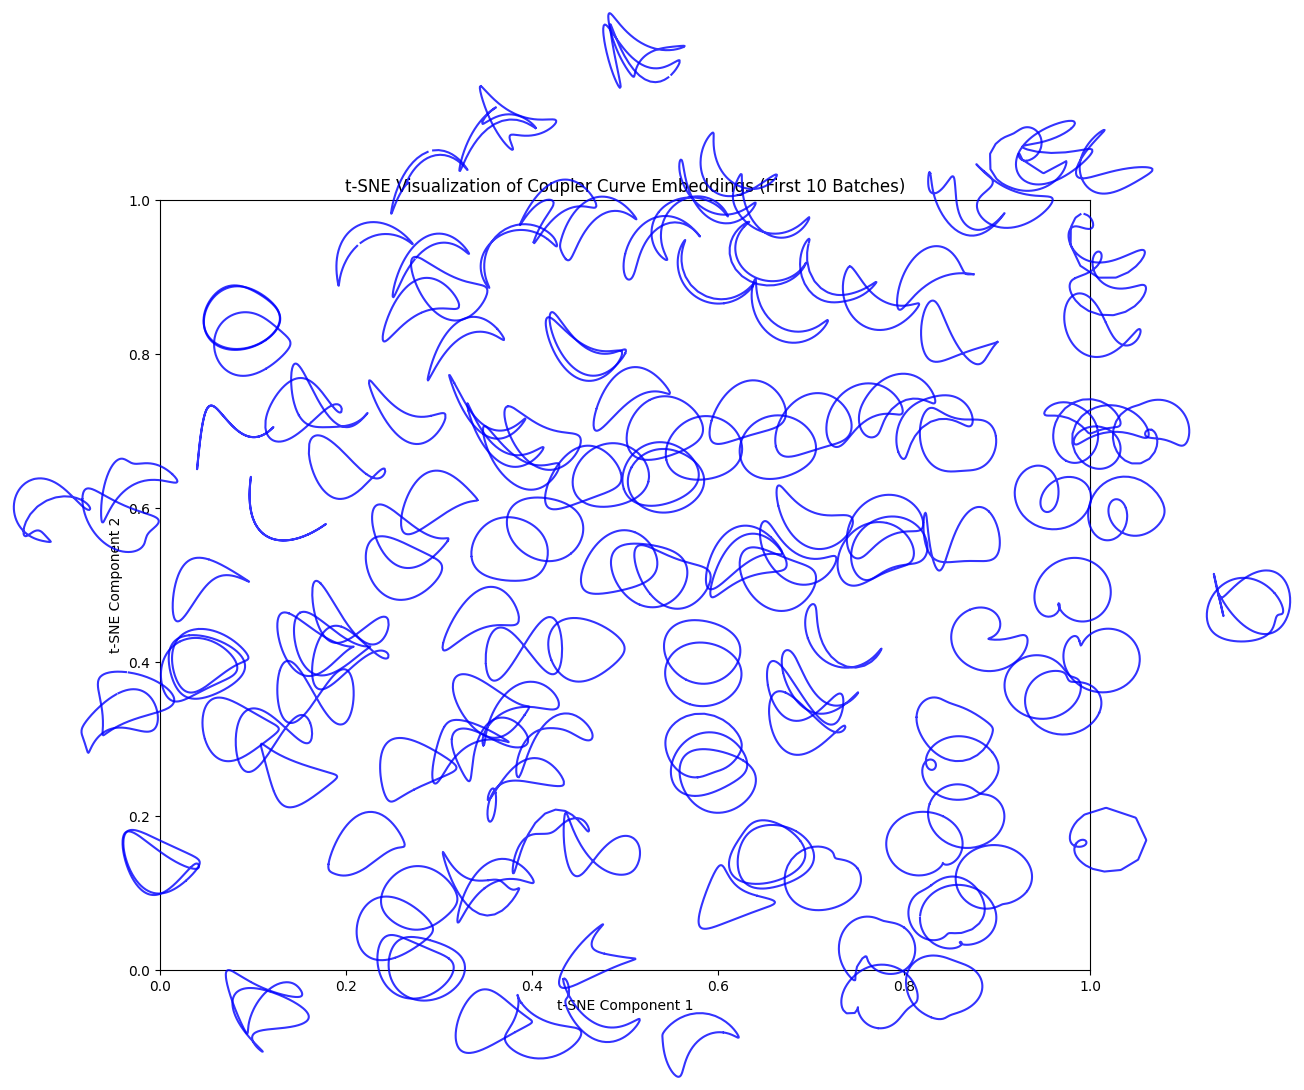

In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import DataLoader
from model import Transformer
from dataset import TransformerDataset
from utils import load_checkpoint

# Define dataset path
dataset_path = "dataset/"

# Load dataset
dataset = TransformerDataset(
    node_features_path=os.path.join(dataset_path, 'node_features.npy'),
    edge_index_path=os.path.join(dataset_path, 'edge_index.npy'),
    curves_path=os.path.join(dataset_path, 'curves.npy'),
    shuffle=False
)

# Set batch size
batch_size = 16  
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Define model checkpoint path
checkpoint_path = "weights/bs_128_lr_0.0001.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model and set to evaluation mode
model = Transformer(output_size=2, tgt_seq_len=14).to(device)
model = load_checkpoint(model, checkpoint_path, device)
model.eval()

# Storage for embeddings and corresponding coupler curves
curve_embeddings = []
curve_data_list = []  # Store actual (x,y) coordinates of curves

# Disable gradient computation for inference
with torch.no_grad():
    for i, batch in enumerate(dataloader):
        if i >= 10:  # ✅ Only process first 10 batches
            break
        
        curve_data = batch["curve"].to(device)  # Shape: [batch_size, 200, 2]

        # Get curve embeddings for the batch
        emb = model.contrastive_curve(curve_data).detach().cpu().numpy()
        curve_embeddings.append(emb)

        # Store the actual coupler curve (x, y) coordinates
        curve_data_list.extend(curve_data.cpu().numpy())  # Convert tensor to NumPy

# Convert embeddings to NumPy array for t-SNE
curve_embeddings = np.concatenate(curve_embeddings, axis=0) if curve_embeddings else None
curve_data_list = np.array(curve_data_list)  # Convert curves to NumPy array

print('Running tSNE')

# ✅ Standardize embeddings before t-SNE
scaler = StandardScaler()
curve_embeddings = scaler.fit_transform(curve_embeddings)  # Normalize embeddings

# Apply t-SNE if we have enough data
if curve_embeddings is not None and curve_embeddings.shape[0] > 1:
    tsne = TSNE(n_components=2, perplexity=50, random_state=42)  # ✅ Adjusted perplexity
    reduced_embeddings = tsne.fit_transform(curve_embeddings)

    # ✅ Rescale t-SNE outputs to spread points properly
    scaled_x = (reduced_embeddings[:, 0] - np.min(reduced_embeddings[:, 0])) / np.ptp(reduced_embeddings[:, 0])
    scaled_y = (reduced_embeddings[:, 1] - np.min(reduced_embeddings[:, 1])) / np.ptp(reduced_embeddings[:, 1])

    # Plot t-SNE results with actual coupler curves
    fig, ax = plt.subplots(figsize=(12, 10))

    for i in range(len(scaled_x)):
        x, y = scaled_x[i], scaled_y[i]  # Rescaled t-SNE coordinates
        curve_xy = curve_data_list[i]  # Get corresponding (x, y) coordinates

        # Create a small inset plot for each coupler curve
        inset_ax = fig.add_axes([x, y, 0.07, 0.07])  # Adjusted for better spread
        inset_ax.plot(curve_xy[:, 0], curve_xy[:, 1], color='blue', alpha=0.8)  # Plot curve
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        inset_ax.axis("off")

    ax.set_title("t-SNE Visualization of Coupler Curve Embeddings (First 10 Batches)")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()

else:
    print("Not enough data points for t-SNE. Try increasing the number of selected batches.")


In [ ]:
import torch
import os
from torch_geometric.loader import DataLoader
from model import Transformer  # Your model class
from dataset import TransformerDataset  # Your dataset classimport sys
from utils import *
from sim import *
import matplotlib.pyplot as plt


In [ ]:
dataset_path = "dataset/"

# Load dataset
dataset = TransformerDataset(
    node_features_path=os.path.join(dataset_path, 'node_features.npy'),
    edge_index_path=os.path.join(dataset_path, 'edge_index.npy'),
    curves_path=os.path.join(dataset_path, 'curves.npy'),
    shuffle=False
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
checkpoint_path = "weights/bs_128_lr_0.0001.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# preds = inference(checkpoint_path, dataset_path)
# Load model
model = Transformer(output_size=2, tgt_seq_len=14).to(device)
model = load_checkpoint(model, checkpoint_path, device).eval()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def greedy_decode_conditional(model, curve_data, graph_data, edge_index, batch_data, max_len):
    model = model.to(device)
    
    # Ensure correct device placement
    curve_data, graph_data, edge_index, batch_data = (
        curve_data.to(device), graph_data.to(device), edge_index.to(device), batch_data.to(device)
    )

    # Encode the input
    encoder_output = model.encode(curve_data, graph_data, edge_index, batch_data)

    # Initialize decoders
    decoder_input_first = torch.zeros(1, 1, 2).to(device)  # Start token for decoder 1
    decoder_input_second = torch.zeros(1, 1, 2).to(device)  # Start token for decoder 2

    decoded_first, decoded_second = [], []

    for _ in range(max_len // 2):
        # Build causal masks
        decoder_mask_first = causal_mask(decoder_input_first.size(1)).type_as(decoder_input_first).to(device)
        decoder_mask_second = causal_mask(decoder_input_second.size(1)).type_as(decoder_input_second).to(device)

        # Decode first sequence
        decoder_output_first = model.decode(
            model.decoder_first, encoder_output, None, decoder_input_first, decoder_mask_first, model.decoder_positional_encoding_first
        )
        proj_output_first = model.projection_first(model.projection_norm_first(decoder_output_first))
        next_token_first = proj_output_first[:, -1].unsqueeze(0)
        decoded_first.append(next_token_first.squeeze(0).detach().cpu())
        decoder_input_first = torch.cat([decoder_input_first, next_token_first], dim=1)

        # Decode second sequence
        decoder_output_second = model.decode(
            model.decoder_second, encoder_output, None, decoder_input_second, decoder_mask_second, model.decoder_positional_encoding_second
        )
        proj_output_second = model.projection_second(model.projection_norm_second(decoder_output_second))
        next_token_second = proj_output_second[:, -1].unsqueeze(0)
        decoded_second.append(next_token_second.squeeze(0).detach().cpu())
        decoder_input_second = torch.cat([decoder_input_second, next_token_second], dim=1)

    # Convert to numpy arrays
    return decoder_input_first.squeeze(0).cpu().numpy(), decoder_input_second.squeeze(0).cpu().numpy()

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_joints_with_special_nodes(predicted_joints, edges, node_info, 
                                   curve=None, predicted_curve=None, title="Joints with Edges & Special Nodes", 
                                   save_path=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Identify nodes with value 1 in the first column (highlighted nodes)
    highlighted_indices = np.where(node_info[:, 0] == 1)[0]

    # Identify the special node with value 1 in the third column (unique color)
    special_index = np.where(node_info[:, 2] == 1)[0]

    # Plot predicted joints
    ax.scatter(predicted_joints[:, 0], predicted_joints[:, 1], label="Predicted Joints", 
               marker='x', color='red', alpha=0.7)

    # Highlight the special nodes
    ax.scatter(predicted_joints[highlighted_indices, 0], predicted_joints[highlighted_indices, 1], 
               marker='o', facecolors='none', edgecolors='gold', s=100, label="Highlighted Nodes")

    # Highlight the special node where node_info[:, 2] == 1 (purple color)
    if special_index.size > 0:
        ax.scatter(predicted_joints[special_index, 0], predicted_joints[special_index, 1], 
                   marker='o', facecolors='none', edgecolors='purple', s=120, label="Special Node")

    # Draw edges connecting joints based on edge_info
    for edge in edges.T:  # edge_info is stored as (2, num_edges), so we transpose
        i, j = edge
        ax.plot([predicted_joints[i, 0], predicted_joints[j, 0]], 
                [predicted_joints[i, 1], predicted_joints[j, 1]], 
                linestyle="--", color="red", alpha=0.5)

    # Plot the desired curve (if provided)
    if curve is not None:
        ax.plot(curve[:, 0], curve[:, 1], linestyle="-", color="green", linewidth=2, alpha=0.8, label="Desired Curve")

    # Plot the predicted curve (if provided)
    if predicted_curve is not None:
        ax.plot(predicted_curve[:, 0], predicted_curve[:, 1], linestyle="--", color="orange", linewidth=2, alpha=0.8, label="Predicted Curve")

    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)  # Free memory after saving
    else:
        plt.show()


In [ ]:
import torch
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the 100 unique mechanisms
save_dir = "mechanism_graphs"
load_path = os.path.join(save_dir, "unique_mechanism_graphs.pkl")

with open(load_path, "rb") as f:
    unique_mechanisms = pickle.load(f)

print(f"Loaded {len(unique_mechanisms)} unique mechanisms.")

# Create results folder if it doesn't exist
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

with torch.no_grad():
    for curve_idx, batch in enumerate(dataloader):
        curve = batch["curve"]
        curve = preprocess_curves(curve).clone().detach().cpu().numpy().squeeze()

        # Create a subfolder for each curve (1/, 2/, 3/, ...)
        curve_folder = os.path.join(results_dir, str(curve_idx + 1))
        os.makedirs(curve_folder, exist_ok=True)

        for mech_id, mechanism in unique_mechanisms.items():
            edge_info = mechanism["edge_index"]
            node_info = mechanism["node_features"]

            # Create adjacency matrix
            A = create_adjacency_matrix(edge_info)
            node_types = node_info[:, 0] != 0
            coupler_point = node_info[:, 2]

            # Find the index of the coupler point
            coupler_point = np.argmax(coupler_point)

            # Use greedy decoding
            pred_first, pred_second = greedy_decode_conditional(
                model,
                batch["curve"].to(device),
                torch.tensor(node_info, dtype=torch.float32).to(device),
                torch.tensor(edge_info, dtype=torch.long).to(device),
                torch.zeros(node_info.shape[0], dtype=torch.long).to(device),  # Dummy batch index
                max_len=14
            )
            
            # Convert predictions to numpy
            pred_first, pred_second = pred_first.reshape(-1, 2), pred_second.reshape(-1, 2)

            # Process predictions separately
            pred_first = truncate_at_closest_with_tolerance(pred_first)
            pred_second = truncate_at_closest_with_tolerance(pred_second)

            # Mask to remove invalid points (values of 0.)
            mask_first = ~(pred_first == 0.).any(axis=1) 
            mask_second = ~(pred_second == 0.).any(axis=1)

            # Apply masks
            pred_first = pred_first[mask_first]
            pred_second = pred_second[mask_second]

            # Concatenate predicted joint positions
            x0_predicted = np.vstack((pred_first, pred_second))

            # Simulate the mechanism
            try:
                x_sol = simulate_mechanism(A, x0_predicted, node_types)
                if x_sol is None:
                    raise ValueError("Simulation failed")
                
                # Extract the trajectory of the coupler point
                x_sol = x_sol[coupler_point]
                x_sol = torch.tensor(x_sol, dtype=torch.float32).unsqueeze(0)
                x_sol = preprocess_curves(x_sol).numpy().squeeze()

                # Save the plot as an image (without displaying it)
                plot_joints_with_special_nodes(
                    predicted_joints=x0_predicted, 
                    edges=edge_info, 
                    node_info=node_info,
                    curve=curve,  # Desired path
                    predicted_curve=x_sol,  # Simulated path based on prediction
                    title=f"Curve {curve_idx} with Mechanism {mech_id}",
                    save_path=os.path.join(curve_folder, f"mechanism_{mech_id}.png")  # Save here
                )

            except Exception as e:
                pass

        print(f"Processed Curve {curve_idx + 1}, results saved in {curve_folder}")

print("Finished processing all curves.")


In [ ]:
import torch
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the 100 unique mechanisms
save_dir = "mechanism_graphs"
load_path = os.path.join(save_dir, "unique_mechanism_graphs.pkl")

with open(load_path, "rb") as f:
    unique_mechanisms = pickle.load(f)

# Tracking success and failure counts
total_curves = 0
total_successes = 0
total_fails = 0
curve_success_rates = []

with torch.no_grad():
    for curve_idx, batch in enumerate(dataloader):
        total_curves += 1
        curve = batch["curve"]
        curve = preprocess_curves(curve).clone().detach().cpu().numpy().squeeze()

        curve_success_count = 0
        curve_fail_count = 0

        for mech_id, mechanism in unique_mechanisms.items():
            edge_info = mechanism["edge_index"]
            node_info = mechanism["node_features"]

            # Create adjacency matrix
            A = create_adjacency_matrix(edge_info)
            node_types = node_info[:, 0] != 0
            coupler_point = node_info[:, 2]

            # Find the index of the coupler point
            coupler_point = np.argmax(coupler_point)

            # Use greedy decoding
            pred_first, pred_second = greedy_decode_conditional(
                model,
                batch["curve"].to(device),
                torch.tensor(node_info, dtype=torch.float32).to(device),
                torch.tensor(edge_info, dtype=torch.long).to(device),
                torch.zeros(node_info.shape[0], dtype=torch.long).to(device),  # Dummy batch index
                max_len=14
            )
            
            # Convert predictions to numpy
            pred_first, pred_second = pred_first.reshape(-1, 2), pred_second.reshape(-1, 2)

            # Process predictions separately with tolerance-based truncation
            pred_first = truncate_at_closest_with_tolerance(pred_first)
            pred_second = truncate_at_closest_with_tolerance(pred_second)

            # Mask to remove invalid points (values of 0.)
            mask_first = ~(pred_first == 0.).any(axis=1) 
            mask_second = ~(pred_second == 0.).any(axis=1)

            # Apply masks
            pred_first = pred_first[mask_first]
            pred_second = pred_second[mask_second]

            # Concatenate predicted joint positions
            x0_predicted = np.vstack((pred_first, pred_second))

            # Simulate the mechanism with error handling
            try:
                x_sol = simulate_mechanism(A, x0_predicted, node_types)
                if x_sol is None:
                    raise ValueError("Simulation returned None")
                curve_success_count += 1
                total_successes += 1
            except:
                curve_fail_count += 1
                total_fails += 1

        # Compute success rate per curve
        curve_total_tests = curve_success_count + curve_fail_count
        curve_success_rate = curve_success_count / curve_total_tests if curve_total_tests > 0 else 0
        curve_success_rates.append(curve_success_rate)

        # Print results for this curve immediately
        print(f"Curve {curve_idx}: {curve_success_count} worked, {curve_fail_count} failed. Success Rate: {curve_success_rate:.2%}")
        print('-' * 80)

# Compute overall success rate
overall_success_rate = total_successes / (total_successes + total_fails) if (total_successes + total_fails) > 0 else 0

# Print final summary after processing all curves
print("\n--- Final Summary ---")
print(f"Total Curves Processed: {total_curves}")
print(f"Total Mechanism Tests: {total_successes + total_fails}")
print(f"Total Successes: {total_successes}")
print(f"Total Fails: {total_fails}")
print(f"Overall Success Rate: {overall_success_rate:.2%}")

# Plot success rate distribution
plt.figure(figsize=(10, 5))
plt.hist(curve_success_rates, bins=20, alpha=0.75)
plt.xlabel('Success Rate per Curve')
plt.ylabel('Frequency')
plt.title('Distribution of Success Rates Across Curves')
plt.show()


In [ ]:
import torch
import pickle
import os
import numpy as np

# Directory to save mechanism graphs
save_dir = "mechanism_graphs"
os.makedirs(save_dir, exist_ok=True)

# Storage dictionary for unique mechanisms
unique_mechanisms = {}
unique_hashes = set()

with torch.no_grad():
    for i, batch in enumerate(dataloader):
        if len(unique_mechanisms) >= 1000:
            break  # Stop once we have 100 unique mechanisms

        # Extract graph data
        edge_info = batch["data"].edge_index.clone().detach().cpu().numpy()
        node_info = batch["data"].x.clone().detach().cpu().numpy()

        # Generate a unique hash based on edge and node information
        mechanism_hash = hash((tuple(map(tuple, edge_info.T)), tuple(map(tuple, node_info))))

        # Only save if it's a new mechanism
        if mechanism_hash not in unique_hashes:
            unique_hashes.add(mechanism_hash)
            unique_mechanisms[f"mechanism_{len(unique_mechanisms)}"] = {
                "edge_index": edge_info,
                "node_features": node_info
            }

# Save 100 unique mechanisms to a Pickle file
save_path = os.path.join(save_dir, "unique_mechanism_graphs.pkl")
with open(save_path, "wb") as f:
    pickle.dump(unique_mechanisms, f)

print(f"Saved {len(unique_mechanisms)} unique mechanism graphs to {save_path}")


In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# with torch.no_grad():
#     for i, batch in enumerate(dataloader):
#         if i >= 10:
#             break  # Stop after processing 10 batches

#         # Extract batch information
#         first_label = batch["label_first"].clone().detach().cpu().numpy()
#         second_label = batch["label_second"].clone().detach().cpu().numpy()
#         edge_info = batch["data"].edge_index.clone().detach().cpu().numpy()
#         node_info = batch["data"].x.clone().detach().cpu().numpy()
#         curve = batch["curve"].clone().detach().cpu().numpy().squeeze()

#         # Use greedy decoding to get predictions
#         pred_first, pred_second = greedy_decode_conditional(
#             model,
#             batch["curve"].to(device),
#             batch["data"].x.to(device),
#             batch["data"].edge_index.to(device),
#             batch["data"].batch.to(device),
#             max_len=12  # Ensure consistent length
#         )

#         # Convert predictions to numpy
#         pred_first, pred_second = pred_first, pred_second

#         # Create adjacency matrix
#         A = create_adjacency_matrix(edge_info)
#         node_types = node_info[:, 0] != 0
#         coupler_point = node_info[:, 2]

#         # Find the index of the coupler point
#         coupler_point = np.argmax(coupler_point)

#         # Reshape to 2D (if necessary)
#         first_original = first_label.reshape(-1, 2)
#         second_original = second_label.reshape(-1, 2)

#         # Mask to remove invalid points (values of 1. or -1.)
#         mask_first = ~((first_original == 1.).any(axis=1) | (first_original == -1.).any(axis=1))
#         mask_second = ~((second_original == 1.).any(axis=1) | (second_original == -1.).any(axis=1))

#         # Apply masks
#         filtered_first = first_original[mask_first]
#         filtered_second = second_original[mask_second]

#         # Concatenate original mechanism joints
#         x0 = np.vstack((filtered_first, filtered_second))

#         # Reshape predictions
#         pred_first = pred_first.reshape(-1, 2)
#         pred_second = pred_second.reshape(-1, 2)

#         # Process predictions separately
#         filtered_first = truncate_at_closest(pred_first)
#         filtered_second = truncate_at_closest(pred_second)
        
#         # Mask to remove rows containing zeros
#         mask_first = ~((filtered_first == 0.).any(axis=1))
#         mask_second = ~((filtered_second == 0.).any(axis=1))

#         filtered_first = filtered_first[mask_first]
#         filtered_second = filtered_second[mask_second]

#         # Concatenate processed predictions
#         x0_predicted = np.concatenate((filtered_first, filtered_second), axis=0)
        
#         # Simulate the mechanism
#         x_sol = simulate_mechanism(A, x0_predicted, node_types)
        
#         if x_sol is None:
#             print('-' * 50)
#             print(f"Shape of node_info: {node_info.shape}")
#             print(f"Shape of x0_predicted: {x0_predicted.shape}")
#             print(x0_predicted)
#             print(f"Shape of x0: {x0.shape}")
#             print(x0)
#             # Compute L2 distance between x0 and x0_predicted if dimensions match
#             if x0.shape == x0_predicted.shape:
#                 l2_distance = np.linalg.norm(x0 - x0_predicted)
#                 print(f"L2 distance between x0 and x0_predicted: {l2_distance}")
#             print(f"Shape of node_types: {node_types.shape}, Values: {node_types}")
#             print(f"Shape of coupler_point: {coupler_point.shape}, Values: {coupler_point}")
#             print('-' * 50)
#             continue

#         # Extract the trajectory of the coupler point
#         x_sol = x_sol[coupler_point]
#         x_sol = torch.tensor(x_sol, dtype=torch.float32).unsqueeze(0)
#         x_sol = preprocess_curves(x_sol).numpy().squeeze()

#         # **Plot the mechanism (Joints & Edges)**
#         plot_joints_with_special_nodes(x0, x0_predicted, edge_info, node_info, title="Joints with Edges & Special Nodes")

#         # **Plot the predicted vs. desired path**
#         plt.figure(figsize=(8, 6))
#         plt.plot(x_sol[:, 0], x_sol[:, 1], label="Predicted Path", linestyle="--", color="blue")
#         plt.plot(curve[:, 0], curve[:, 1], label="Desired Path", linestyle="-", color="red")
#         plt.legend()
#         plt.xlabel("X")
#         plt.ylabel("Y")
#         plt.title("Predicted vs. Desired Path")
#         plt.grid()
#         plt.show()
